In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import pandas as pd
import pickle
import re
import math
import optuna
# ここから自作
import model
import result
import mode
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, target, transform=None):
        self.transform = transform
        self.data = data
        self.target = target
   
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        out_data = self.data[index]
        out_target = self.target[index]
        
        return out_data, out_target

In [3]:
# 時刻を表示してくれるようになるprint関数のwrapper
def datePrint(*args, **kwargs):
    from datetime import datetime
    print(datetime.now().strftime('[%Y/%m/%d %H:%M:%S] '), end="")
    print(*args, **kwargs)

In [4]:
datePrint("loading pickle data")
input1 = torch.tensor(pickle.load(open("../data/r-make/maxspan100/seq_1.pkl","rb")))
target1 = torch.tensor(pickle.load(open("../data/r-make/maxspan100/target_1.pkl","rb"))).float()
target1 = torch.flip(target1, dims=[1])
input2 = torch.tensor(pickle.load(open("../data/r-make/maxspan100/seq_2.pkl","rb")))
target2 = torch.tensor(pickle.load(open("../data/r-make/maxspan100/target_2.pkl","rb"))).float()
target2 = torch.flip(target2, dims=[1])
input3 = torch.tensor(pickle.load(open("../data/r-make/maxspan100/seq_3.pkl","rb")))
target3 = torch.tensor(pickle.load(open("../data/r-make/maxspan100/target_3.pkl","rb"))).float()
target3 = torch.flip(target3, dims=[1])
# input4 = torch.tensor(pickle.load(open("../data/r-make/maxspan100/seq_4.pkl","rb")))
# target4 = torch.tensor(pickle.load(open("../data/r-make/maxspan100/target_4.pkl","rb"))).float()
# target4 = torch.flip(target4, dims=[1])
# input5 = torch.tensor(pickle.load(open("../data/r-make/maxspan100/seq_5.pkl","rb")))
# target5 = torch.tensor(pickle.load(open("../data/r-make/maxspan100/target_5.pkl","rb"))).float()
# target5 = torch.flip(target5, dims=[1])

input_all = torch.cat([input1, input2, input3], dim=0)
target_all = torch.cat([target1, target2, target3], dim=0)

dataset = model.Dataset(input_all, target_all)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [1200000, 300000])

[2022/03/20 17:46:38] loading pickle data


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended t

In [5]:
# costom loss軍団
    
class CosineLoss(nn.Module):
    def __init__(self):
        super(CosineLoss, self).__init__()

    def forward(self, outputs, targets):
        return torch.sum(1 - nn.functional.cosine_similarity(outputs, targets, dim=-1, eps=1e-6))

class HyperbolicLoss(nn.Module):
    def __init__(self):
        super(HyperbolicLoss, self).__init__()

    def forward(self, u, v, epsilon=1e-7):
        sqdist = torch.sum((u - v) ** 2, dim=-1)
        squnorm = torch.sum(u ** 2, dim=-1)
        sqvnorm = torch.sum(v ** 2, dim=-1)
        x = 1 + 2 * sqdist / ((1 - squnorm) * (1 - sqvnorm)) + epsilon
        z = torch.sqrt(x ** 2 - 1)
        return torch.sum(z)

# from geomstats.geometry.poincare_ball import PoincareBall
# class PoincareBallLoss(nn.Module):
#     def __init__(self):
#         super(PoincareBallLoss, self).__init__()
        
#     def forward(self, output, target):
#         output = output.cpu().detach().numpy()
#         target = target.cpu().detach().numpy()
#         return float(PoincareBall(dim=8).metric.dist(output[0], target[0]))


losses = [nn.MSELoss]
lrs = [1e-4, 5e-4, 1e-3]
# opts = [optim.Adam, optim.RMSprop, optim.Adamax]

In [6]:
class conv1DBatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1):
        super(conv1DBatchNorm, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias=False)
        self.batchnorm = nn.BatchNorm1d(out_channels)
        
    def forward(self, x):
        x = self.conv(x)
        output = self.batchnorm(x)

        return output

class conv1DBatchNormMish(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1):
        super(conv1DBatchNormMish, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias=False)
        self.batchnorm = nn.BatchNorm1d(out_channels)
        self.mish = nn.Mish(inplace=True)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        output = self.mish(x)

        return output
    
class scSE(nn.Module):
    def __init__(self, channels, reduction=4):
        super(scSE, self).__init__()
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(channels, channels//reduction, bias=False)
        self.fc2 = nn.Linear(channels//reduction, channels, bias=False)
        
        self.conv = nn.Conv1d(channels, 1, kernel_size=1)

        self.sig = nn.Sigmoid()

    def forward(self, x):
        batch, channel, _ = x.size()
        c = self.gap(x).view(batch, channel)
        c = self.sig(self.fc2(F.relu(self.fc1(c)))).view(batch, channel, 1)
        c = x * c
        
        s = self.sig(self.conv(x))
        s = x * s
        return c + s


In [7]:
class CT(nn.Module):
    def __init__(self):
        super(CT, self).__init__()
        self.conv = conv1DBatchNormMish(in_channels=1, out_channels=1, kernel_size=5)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=508, nhead=4, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=4)

    def forward(self, data):
        batch, length = data.shape
        data =  data.reshape(batch, -1, length) #(batch, emb=1, length=512)
        output = self.encoder(self.conv(data))
        
        output = output.view(output.shape[0], -1)
        return output

class TC(nn.Module):
    def __init__(self):
        super(TC, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=4)
        self.conv = conv1DBatchNorm(in_channels=1, out_channels=1, kernel_size=5)

    def forward(self, data):
        batch, length = data.shape
        data =  data.reshape(batch, -1, length) #(batch, emb=1, length=512)
        output = self.conv(self.encoder(data))
        
        output = output.view(output.shape[0], -1)
        return output

class CTC(nn.Module):
    def __init__(self):
        super(CTC, self).__init__()
        self.convm = conv1DBatchNormMish(in_channels=1, out_channels=32, kernel_size=3)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=510, nhead=6, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=4)
        self.conv = conv1DBatchNorm(in_channels=32, out_channels=1, kernel_size=3)

    def forward(self, data):
        batch, length = data.shape
        data =  data.reshape(batch, -1, length) #(batch, emb=1, length=512)
        output = self.conv(self.encoder(self.convm(data)))
        
        output = output.view(output.shape[0], -1)
        return output


In [8]:
def objective(trial):
    batch_size = 256
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    
    dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}
    
    model_name = trial.suggest_categorical('model', ['CT', 'TC', 'CTC'])
    if model_name=='CT':
        model = CT().to(device)
    elif model_name=='TC':
        model = TC().to(device)
    elif model_name=='CTC':
        model = CTC().to(device)
    
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-7, 1e-3)
    optimizer = optim.RAdam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    epochs = 10
    criterion = nn.MSELoss().to(device)
    print(f'model:{model_name}, lr:{lr:.3e}, wd:{weight_decay:.3e}')
    train_loss_list, val_loss_list, data_all, target_all, output_all = mode.train(device, model, dataloaders_dict, criterion, optimizer, epochs)               
    
    return float(val_loss_list[-1])

[I 2022-03-20 17:46:55,299] A new study created in memory with name: no-name-18f5e488-aaba-45e2-bb27-d2fe4f2b911f


model:CT, lr:3.453e-04, wd:2.549e-06
Epoch 1/10
val Loss:12.9974 Timer:5.8589
Epoch 2/10
train Loss:8.3083 Timer:83.0418
val Loss:4.3320 Timer:5.9551
Epoch 3/10
train Loss:3.4990 Timer:90.1394
val Loss:3.1797 Timer:6.3176
Epoch 4/10
train Loss:3.1970 Timer:84.7710
val Loss:3.1276 Timer:6.0420
Epoch 5/10
train Loss:3.1689 Timer:88.6378
val Loss:3.1179 Timer:25.5880


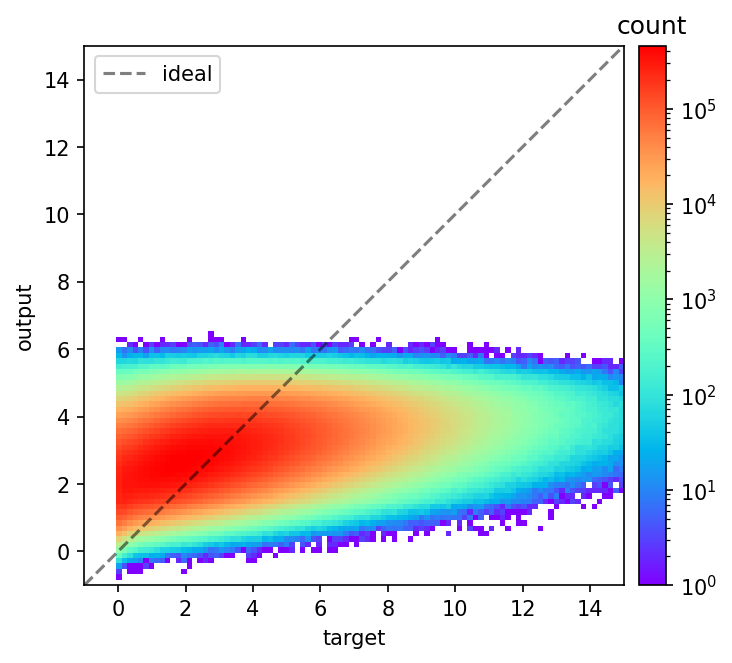

Epoch 6/10
train Loss:3.1570 Timer:91.3711
val Loss:3.1125 Timer:6.0885
Epoch 7/10
train Loss:3.1483 Timer:84.5823
val Loss:3.1114 Timer:6.0882
Epoch 8/10
train Loss:3.1419 Timer:85.6569
val Loss:3.1096 Timer:6.3673
Epoch 9/10
train Loss:3.1369 Timer:85.1098
val Loss:3.1061 Timer:6.5690
Epoch 10/10
train Loss:3.1333 Timer:86.2112
val Loss:3.1059 Timer:28.7293


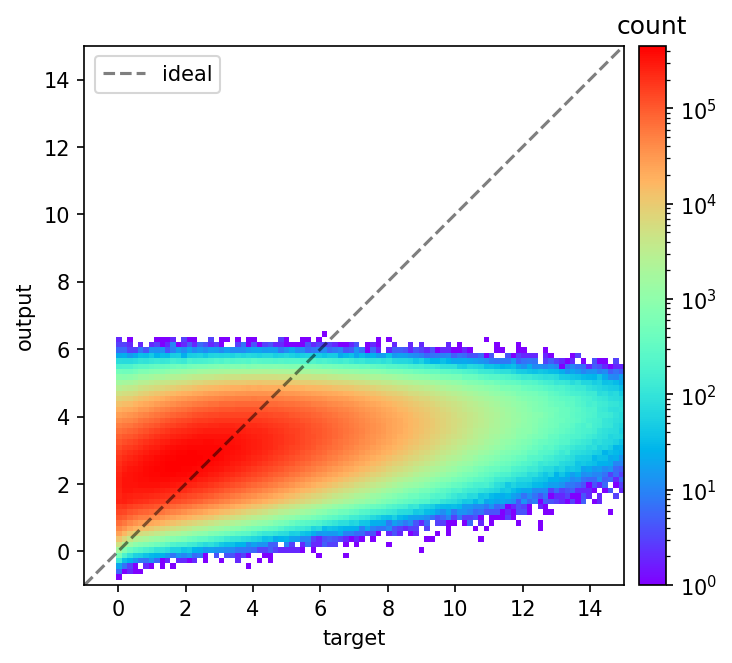

[I 2022-03-20 18:02:40,883] Trial 0 finished with value: 3.1058964458211262 and parameters: {'model': 'CT', 'lr': 0.00034534625178683374, 'weight_decay': 2.5490960896803347e-06}. Best is trial 0 with value: 3.1058964458211262.


model:CTC, lr:2.376e-04, wd:1.549e-07
Epoch 1/10
val Loss:12.3382 Timer:28.9115
Epoch 2/10
train Loss:9.5146 Timer:358.1449
val Loss:6.9571 Timer:29.8666
Epoch 3/10
train Loss:5.2675 Timer:368.4342
val Loss:3.8805 Timer:29.6026
Epoch 4/10
train Loss:3.1897 Timer:356.9704
val Loss:2.7423 Timer:28.6778
Epoch 5/10
train Loss:2.6927 Timer:356.0730
val Loss:2.6922 Timer:59.0599


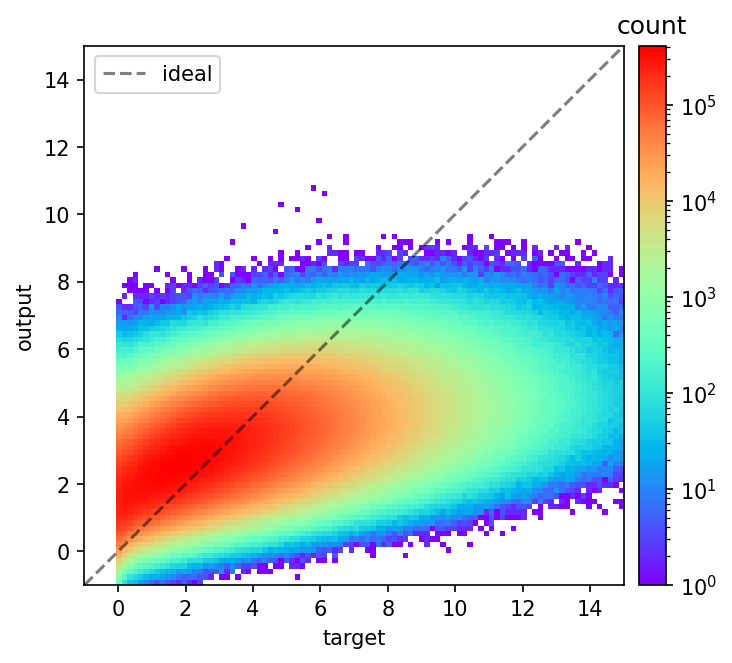

Epoch 6/10
train Loss:2.6486 Timer:365.6802
val Loss:2.7061 Timer:28.8873
Epoch 7/10
train Loss:2.6140 Timer:354.9990
val Loss:2.7227 Timer:29.2305
Epoch 8/10
train Loss:2.5814 Timer:357.9198
val Loss:2.7392 Timer:29.4456
Epoch 9/10
train Loss:2.5528 Timer:362.8137
val Loss:2.7701 Timer:31.7746
Epoch 10/10
train Loss:2.5281 Timer:359.3909
val Loss:2.7760 Timer:50.7469


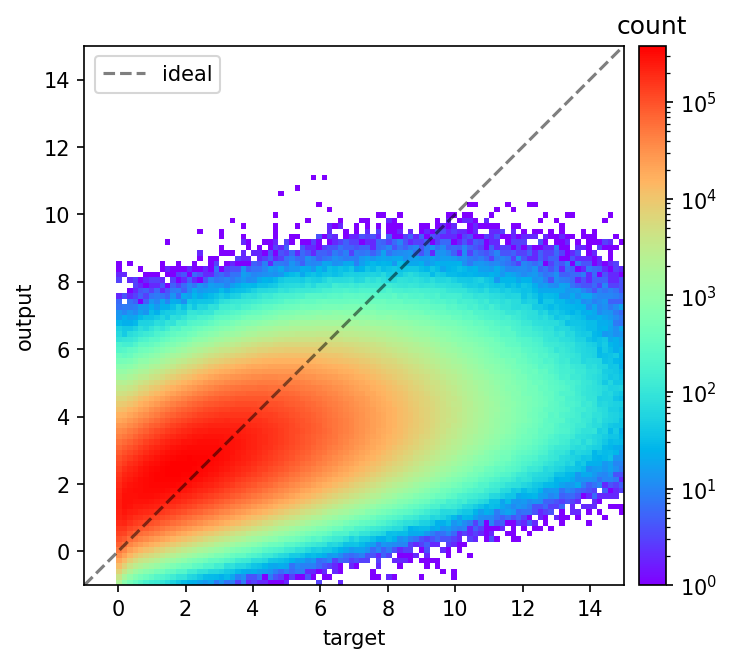

[I 2022-03-20 19:02:55,709] Trial 1 finished with value: 2.775973423614502 and parameters: {'model': 'CTC', 'lr': 0.00023762409086875919, 'weight_decay': 1.5485933618461004e-07}. Best is trial 1 with value: 2.775973423614502.


model:TC, lr:1.842e-03, wd:3.805e-06
Epoch 1/10
val Loss:12.2453 Timer:9.7158
Epoch 2/10
train Loss:5.5520 Timer:95.1279
val Loss:3.4942 Timer:5.7568
Epoch 3/10
train Loss:3.4987 Timer:89.7650
val Loss:3.4751 Timer:5.8346
Epoch 4/10
train Loss:3.4890 Timer:90.4421
val Loss:3.4606 Timer:5.6237
Epoch 5/10
train Loss:3.4784 Timer:89.4753
val Loss:3.4505 Timer:28.9035


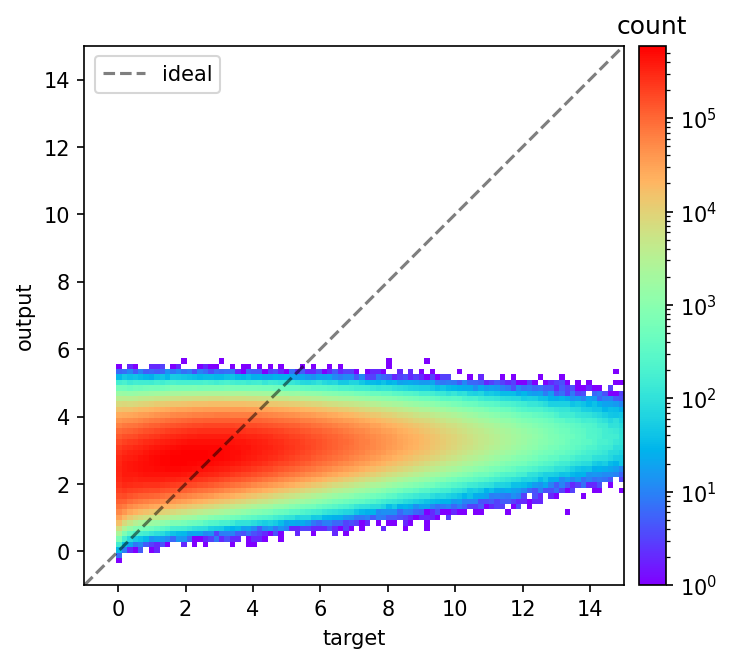

Epoch 6/10
train Loss:3.4744 Timer:80.8204
val Loss:3.4441 Timer:6.5995
Epoch 7/10
train Loss:3.4724 Timer:81.3860
val Loss:3.4452 Timer:5.7575
Epoch 8/10
train Loss:3.4712 Timer:79.6951
val Loss:3.4455 Timer:5.7862
Epoch 9/10
train Loss:3.4703 Timer:81.3244
val Loss:3.4455 Timer:5.6917
Epoch 10/10
train Loss:3.4699 Timer:79.4276
val Loss:3.4437 Timer:26.4719


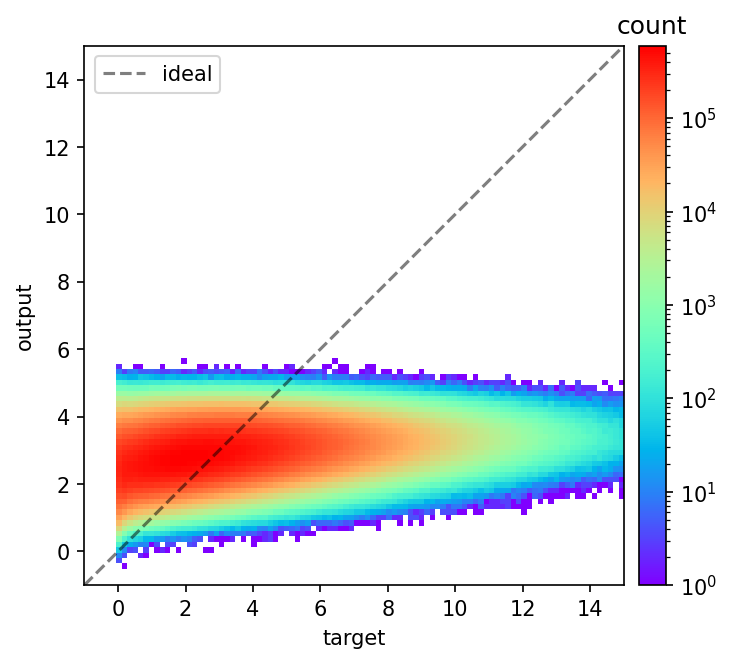

[I 2022-03-20 19:17:54,567] Trial 2 finished with value: 3.443658707046509 and parameters: {'model': 'TC', 'lr': 0.0018422399811133111, 'weight_decay': 3.8053406261152693e-06}. Best is trial 1 with value: 2.775973423614502.


model:TC, lr:1.338e-05, wd:8.071e-06
Epoch 1/10
val Loss:12.6023 Timer:10.0960
Epoch 2/10
train Loss:12.6286 Timer:85.8649
val Loss:12.3886 Timer:9.8751
Epoch 3/10
train Loss:12.1782 Timer:88.5916
val Loss:11.9544 Timer:10.3244
Epoch 4/10
train Loss:11.7414 Timer:87.8528
val Loss:11.5287 Timer:9.7355
Epoch 5/10
train Loss:11.3207 Timer:85.5193
val Loss:11.1155 Timer:32.4745


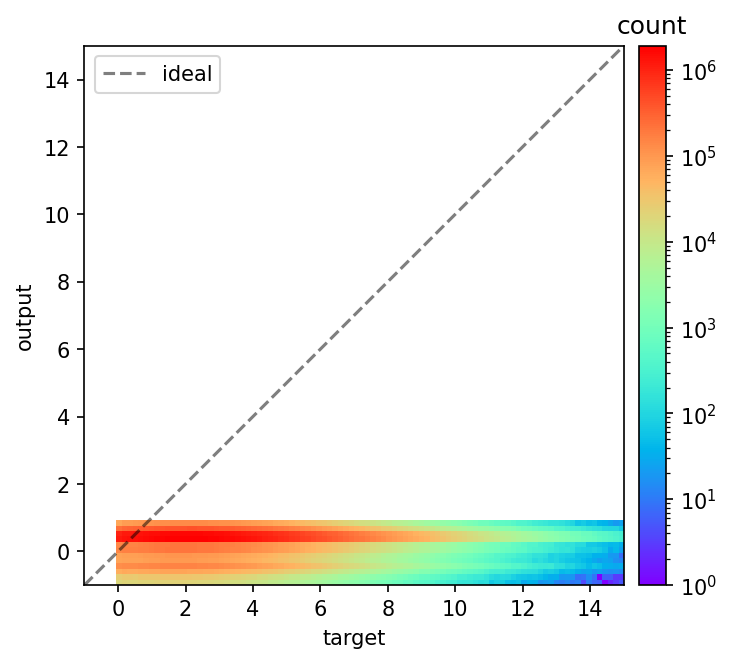

Epoch 6/10
train Loss:10.9157 Timer:80.0349
val Loss:10.7176 Timer:5.8951
Epoch 7/10
train Loss:10.5265 Timer:84.0684
val Loss:10.3350 Timer:5.9896
Epoch 8/10
train Loss:10.1529 Timer:76.6001
val Loss:9.9688 Timer:5.9609
Epoch 9/10
train Loss:9.7947 Timer:76.2589
val Loss:9.6172 Timer:6.0333
Epoch 10/10
train Loss:9.4519 Timer:76.8835
val Loss:9.2814 Timer:29.4283


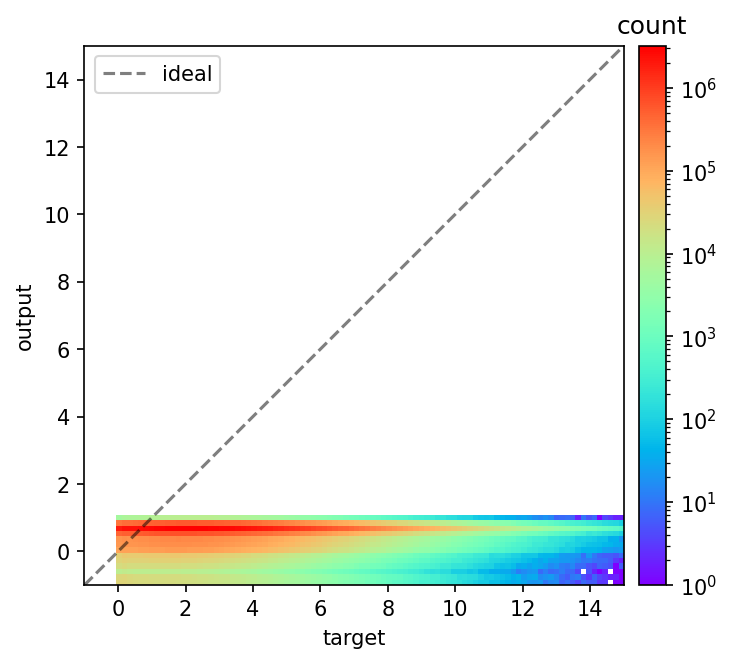

[I 2022-03-20 19:32:43,468] Trial 3 finished with value: 9.281432433573405 and parameters: {'model': 'TC', 'lr': 1.3379509411193909e-05, 'weight_decay': 8.071235828458705e-06}. Best is trial 1 with value: 2.775973423614502.


model:CT, lr:2.554e-03, wd:6.012e-05
Epoch 1/10
val Loss:13.1888 Timer:5.8118
Epoch 2/10
train Loss:4.8238 Timer:94.6666
val Loss:3.3814 Timer:5.7437
Epoch 3/10
train Loss:3.4195 Timer:88.8797
val Loss:3.3236 Timer:5.4209
Epoch 4/10
train Loss:3.3872 Timer:87.3776
val Loss:3.2920 Timer:5.8389
Epoch 5/10
train Loss:3.3700 Timer:88.7298
val Loss:3.2758 Timer:28.7489


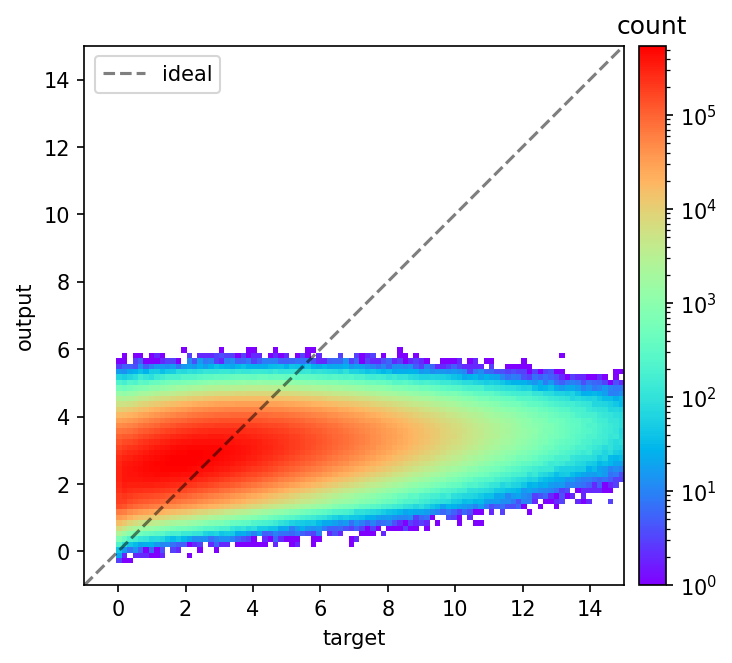

Epoch 6/10
train Loss:3.3590 Timer:86.9851
val Loss:3.2720 Timer:6.1046
Epoch 7/10
train Loss:3.3542 Timer:84.4554
val Loss:3.2571 Timer:5.5341
Epoch 8/10
train Loss:3.3491 Timer:81.6029
val Loss:3.2541 Timer:5.8568
Epoch 9/10
train Loss:3.3468 Timer:81.5743
val Loss:3.2477 Timer:5.8597
Epoch 10/10
train Loss:3.3448 Timer:83.0406
val Loss:3.2400 Timer:28.8690


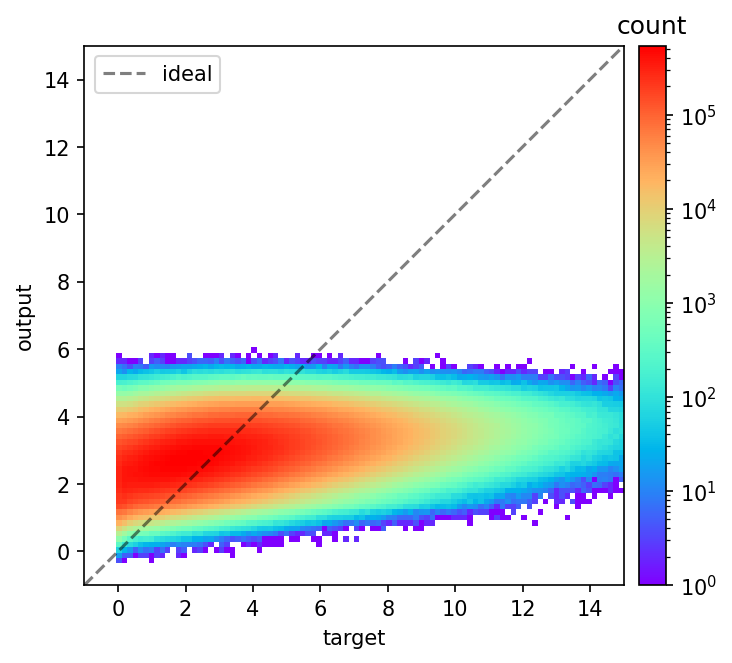

[I 2022-03-20 19:47:48,486] Trial 4 finished with value: 3.2400401211802166 and parameters: {'model': 'CT', 'lr': 0.0025535883723674393, 'weight_decay': 6.0116586326752766e-05}. Best is trial 1 with value: 2.775973423614502.


model:CTC, lr:7.111e-05, wd:4.709e-07
Epoch 1/10
val Loss:12.3238 Timer:28.0677
Epoch 2/10
train Loss:11.9709 Timer:361.8752
val Loss:10.9876 Timer:28.3407
Epoch 3/10
train Loss:10.0213 Timer:370.9223
val Loss:9.1277 Timer:28.9025
Epoch 4/10
train Loss:8.0694 Timer:360.1859
val Loss:7.0407 Timer:28.7099
Epoch 5/10
train Loss:6.2387 Timer:361.9182
val Loss:5.5379 Timer:54.6618


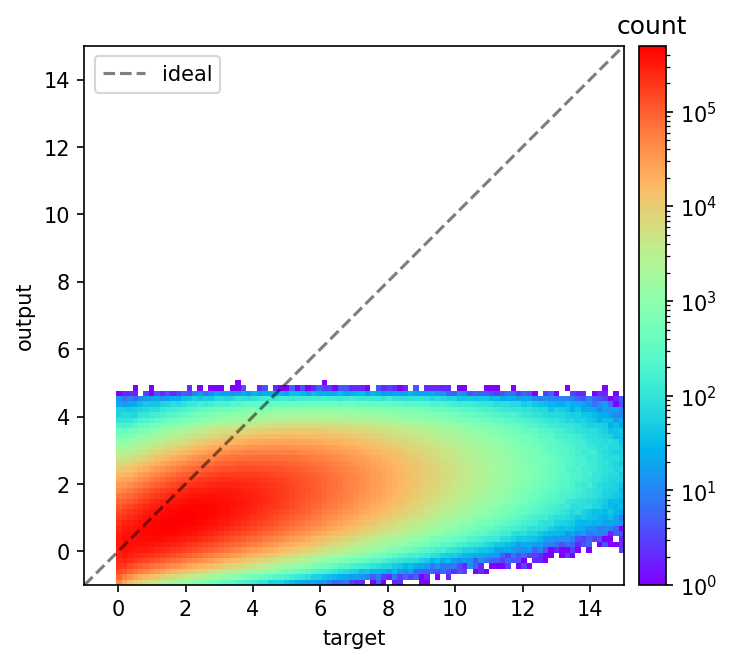

Epoch 6/10
train Loss:5.0177 Timer:358.8886
val Loss:4.5553 Timer:28.5172
Epoch 7/10
train Loss:4.1345 Timer:360.0206
val Loss:3.8194 Timer:28.7684
Epoch 8/10
train Loss:3.4634 Timer:355.2837
val Loss:3.2841 Timer:28.8889
Epoch 9/10
train Loss:2.9987 Timer:352.6825
val Loss:2.9691 Timer:28.7555
Epoch 10/10
train Loss:2.7311 Timer:354.0093
val Loss:2.8343 Timer:54.5238


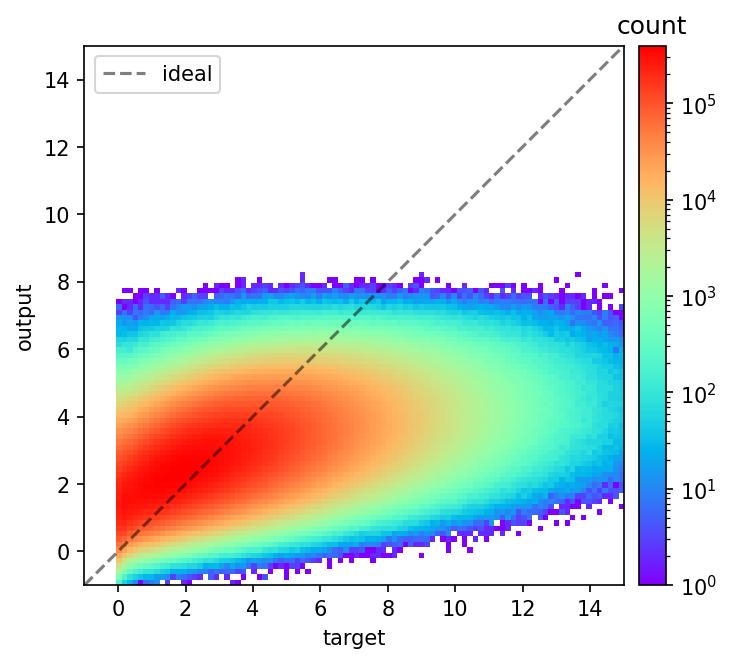

[I 2022-03-20 20:47:50,781] Trial 5 finished with value: 2.834298393122355 and parameters: {'model': 'CTC', 'lr': 7.110839111119615e-05, 'weight_decay': 4.708993374316818e-07}. Best is trial 1 with value: 2.775973423614502.


model:CTC, lr:7.649e-05, wd:3.179e-06
Epoch 1/10
val Loss:12.6124 Timer:28.3102
Epoch 2/10
train Loss:11.9220 Timer:365.7824
val Loss:10.8660 Timer:28.7576
Epoch 3/10
train Loss:9.8494 Timer:360.1590
val Loss:8.9128 Timer:28.4996
Epoch 4/10
train Loss:8.0271 Timer:353.4402
val Loss:6.9305 Timer:28.7442
Epoch 5/10
train Loss:6.0741 Timer:359.6080
val Loss:5.3083 Timer:52.9126


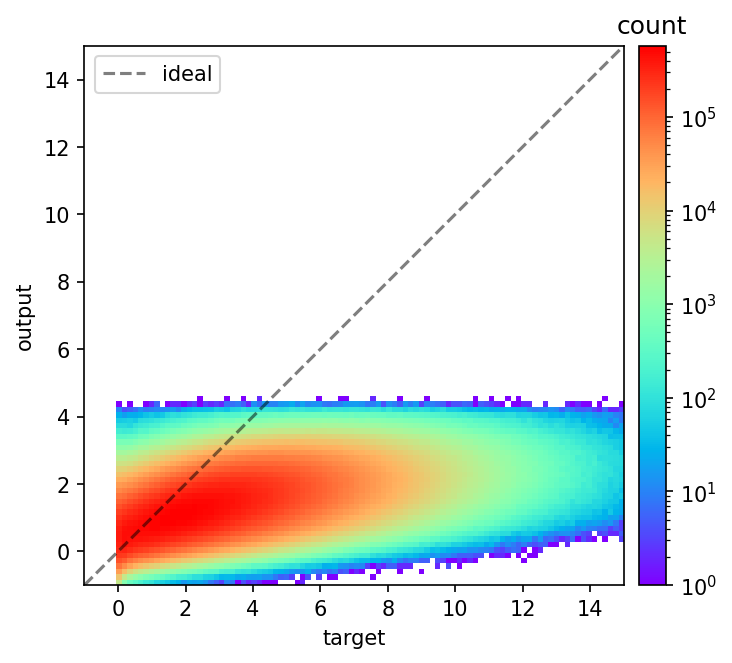

Epoch 6/10
train Loss:4.7566 Timer:361.1245
val Loss:4.2745 Timer:29.1582
Epoch 7/10
train Loss:3.8769 Timer:357.3597
val Loss:3.5704 Timer:28.9266
Epoch 8/10
train Loss:3.2616 Timer:351.2360
val Loss:3.1121 Timer:28.4785
Epoch 9/10
train Loss:2.8770 Timer:354.4992
val Loss:2.8775 Timer:28.9700
Epoch 10/10
train Loss:2.7015 Timer:358.8892
val Loss:2.8265 Timer:52.1779


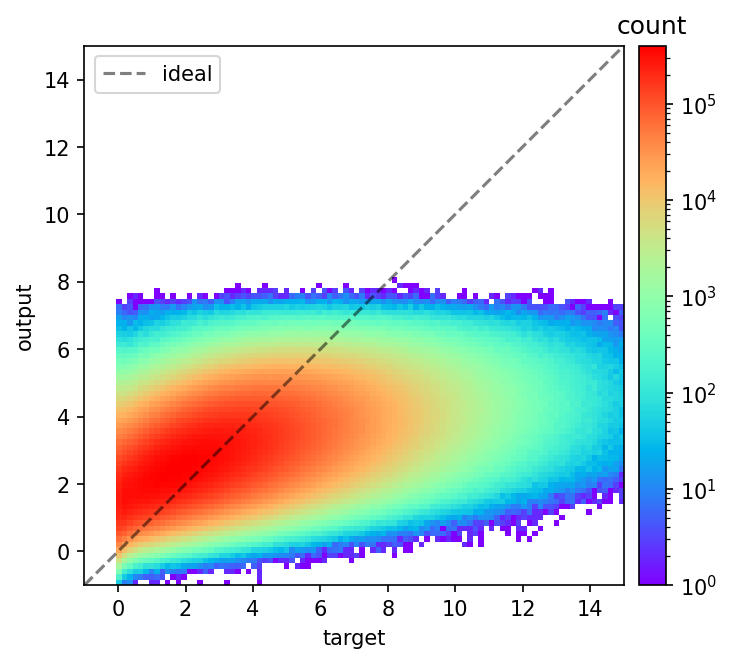

[I 2022-03-20 21:47:34,609] Trial 6 finished with value: 2.8265344778442385 and parameters: {'model': 'CTC', 'lr': 7.649139370158641e-05, 'weight_decay': 3.1792439631283152e-06}. Best is trial 1 with value: 2.775973423614502.


model:CT, lr:8.484e-04, wd:6.602e-05
Epoch 1/10
val Loss:12.8734 Timer:9.7438
Epoch 2/10
train Loss:5.9542 Timer:101.9414
val Loss:3.4453 Timer:10.4142
Epoch 3/10
train Loss:3.4209 Timer:90.3018
val Loss:3.4051 Timer:9.9877
Epoch 4/10
train Loss:3.4122 Timer:91.6823
val Loss:3.4009 Timer:9.1906
Epoch 5/10
train Loss:3.4107 Timer:92.7730
val Loss:3.3978 Timer:31.1469


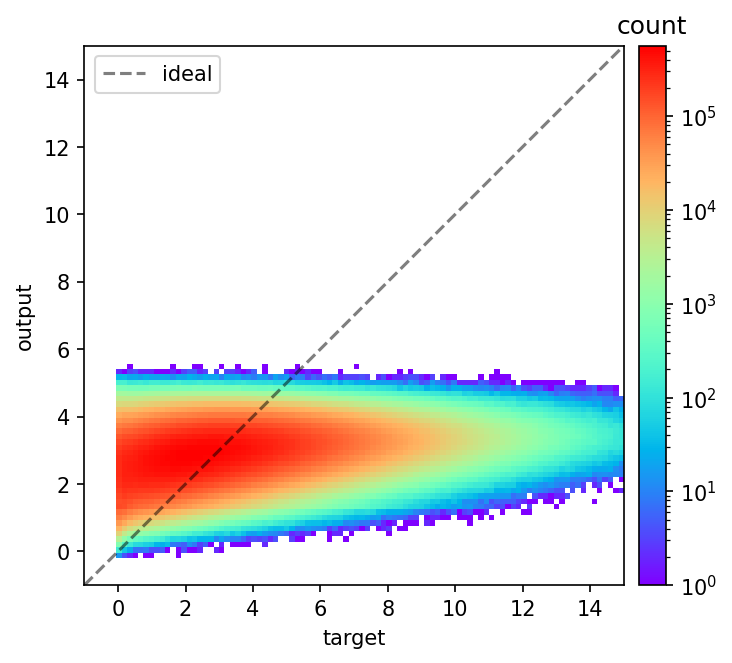

Epoch 6/10
train Loss:3.4095 Timer:90.9157
val Loss:3.3994 Timer:6.1321
Epoch 7/10
train Loss:3.4096 Timer:88.7084
val Loss:3.3999 Timer:6.2702
Epoch 8/10
train Loss:3.4092 Timer:90.3905
val Loss:3.3982 Timer:6.0228
Epoch 9/10
train Loss:3.4090 Timer:87.4036
val Loss:3.3990 Timer:6.4493
Epoch 10/10
train Loss:3.4089 Timer:93.5892
val Loss:3.3988 Timer:34.0509


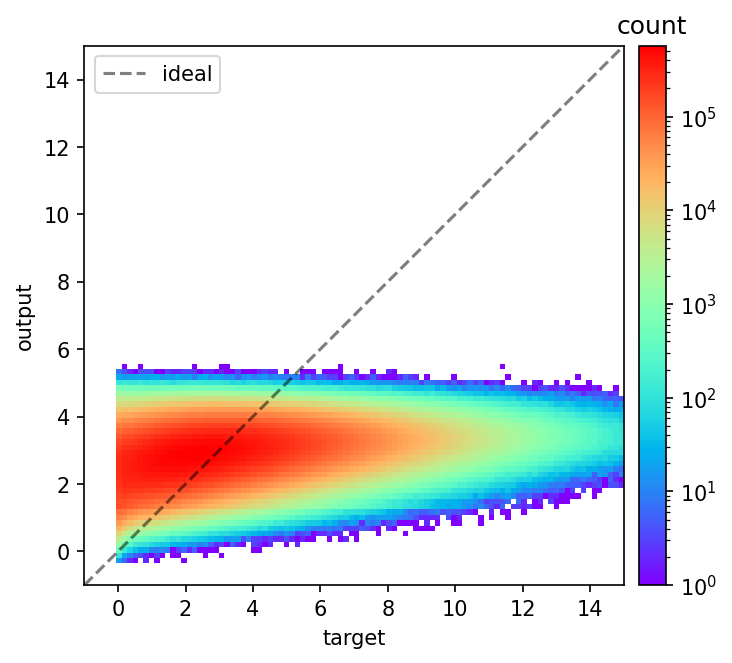

[I 2022-03-20 22:03:58,438] Trial 7 finished with value: 3.3987668896993 and parameters: {'model': 'CT', 'lr': 0.0008484340309597012, 'weight_decay': 6.602494300391832e-05}. Best is trial 1 with value: 2.775973423614502.


model:CT, lr:9.104e-05, wd:1.307e-06
Epoch 1/10
val Loss:12.8252 Timer:5.2748
Epoch 2/10
train Loss:10.9395 Timer:96.7340
val Loss:9.1212 Timer:6.1800
Epoch 3/10
train Loss:7.6056 Timer:90.7568
val Loss:6.2492 Timer:6.3281
Epoch 4/10
train Loss:5.3153 Timer:90.5987
val Loss:4.5218 Timer:5.8930
Epoch 5/10
train Loss:4.0459 Timer:90.0492
val Loss:3.6632 Timer:35.3192


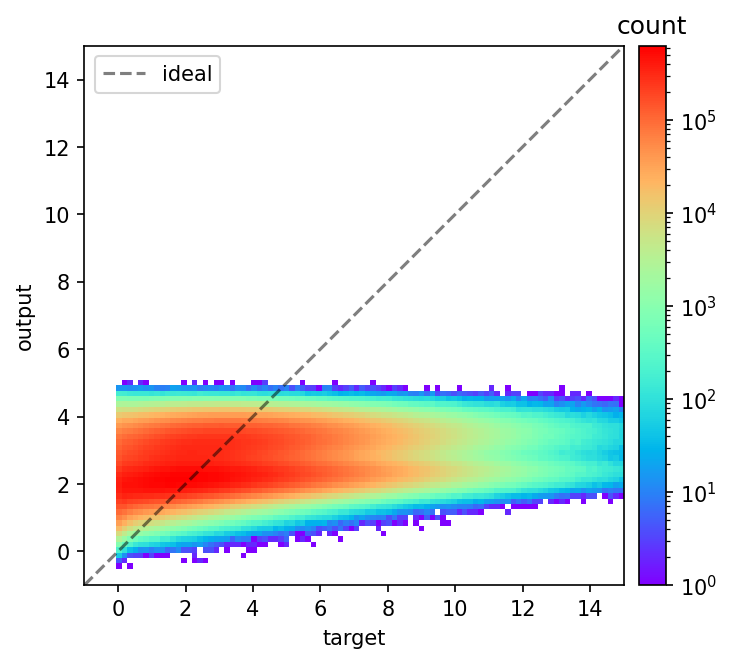

Epoch 6/10
train Loss:3.5075 Timer:96.0423
val Loss:3.3978 Timer:5.8528
Epoch 7/10
train Loss:3.3955 Timer:92.3510
val Loss:3.3807 Timer:5.9416
Epoch 8/10
train Loss:3.3844 Timer:90.0487
val Loss:3.3789 Timer:6.8672
Epoch 9/10
train Loss:3.3773 Timer:88.1832
val Loss:3.3784 Timer:6.3805
Epoch 10/10
train Loss:3.3714 Timer:88.8858
val Loss:3.3772 Timer:27.8608


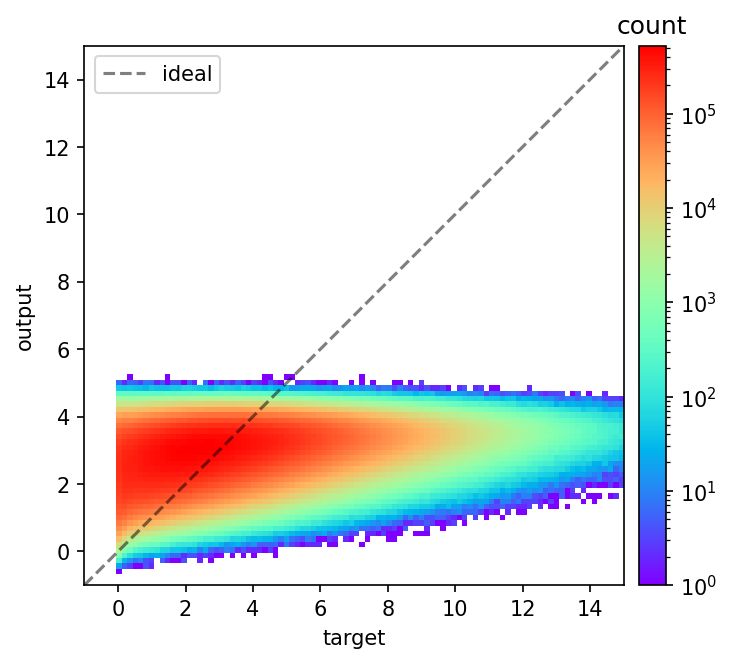

[I 2022-03-20 22:19:58,257] Trial 8 finished with value: 3.3772183644104006 and parameters: {'model': 'CT', 'lr': 9.1041946503882e-05, 'weight_decay': 1.306835298232743e-06}. Best is trial 1 with value: 2.775973423614502.


model:CTC, lr:2.056e-04, wd:9.668e-04
Epoch 1/10
val Loss:13.3088 Timer:34.2375
Epoch 2/10
train Loss:9.6490 Timer:363.2813
val Loss:7.4199 Timer:33.7447
Epoch 3/10
train Loss:5.8059 Timer:359.2367
val Loss:4.4433 Timer:33.0849
Epoch 4/10
train Loss:3.6261 Timer:368.8250
val Loss:3.0374 Timer:33.0072
Epoch 5/10
train Loss:2.8597 Timer:356.1569
val Loss:2.7887 Timer:55.5619


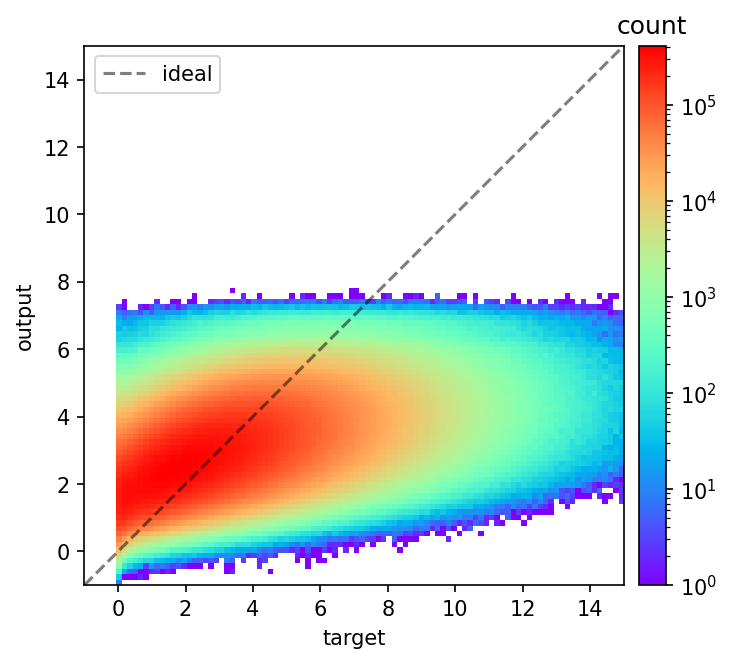

Epoch 6/10
train Loss:2.7937 Timer:354.1536
val Loss:2.7868 Timer:28.5039
Epoch 7/10
train Loss:2.7925 Timer:361.4043
val Loss:2.7865 Timer:30.0163
Epoch 8/10
train Loss:2.7918 Timer:354.4538
val Loss:2.7850 Timer:29.4771
Epoch 9/10
train Loss:2.7912 Timer:356.3215
val Loss:2.7839 Timer:28.3154
Epoch 10/10
train Loss:2.7909 Timer:352.4600
val Loss:2.7836 Timer:49.4577


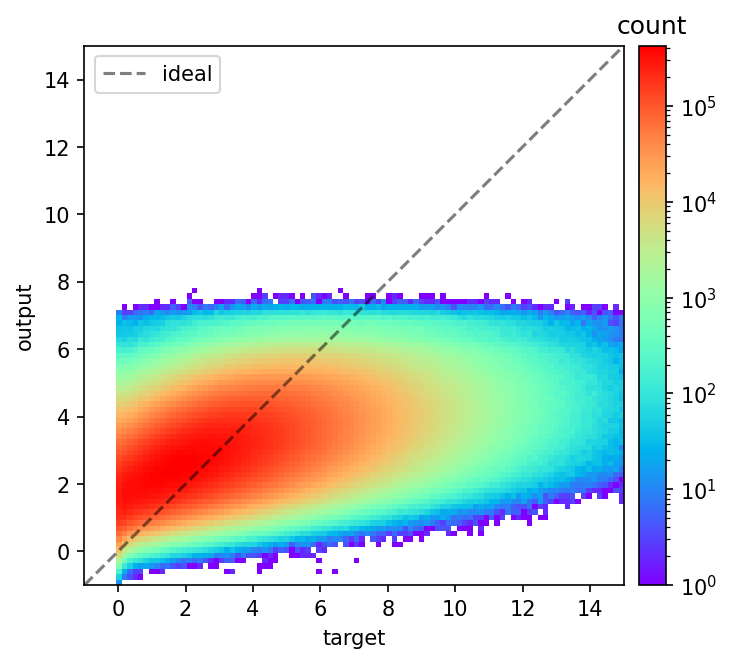

[I 2022-03-20 23:20:06,452] Trial 9 finished with value: 2.7835812964375815 and parameters: {'model': 'CTC', 'lr': 0.00020563995586243437, 'weight_decay': 0.0009667543075574886}. Best is trial 1 with value: 2.775973423614502.


model:CTC, lr:1.590e-05, wd:1.427e-07
Epoch 1/10
val Loss:12.2335 Timer:29.0017
Epoch 2/10
train Loss:11.8073 Timer:366.1032
val Loss:11.1734 Timer:30.6381
Epoch 3/10
train Loss:10.9116 Timer:364.7101
val Loss:10.6529 Timer:29.0437
Epoch 4/10
train Loss:10.4390 Timer:358.4554
val Loss:10.2136 Timer:29.0410
Epoch 5/10
train Loss:10.0112 Timer:358.0925
val Loss:9.7931 Timer:54.2713


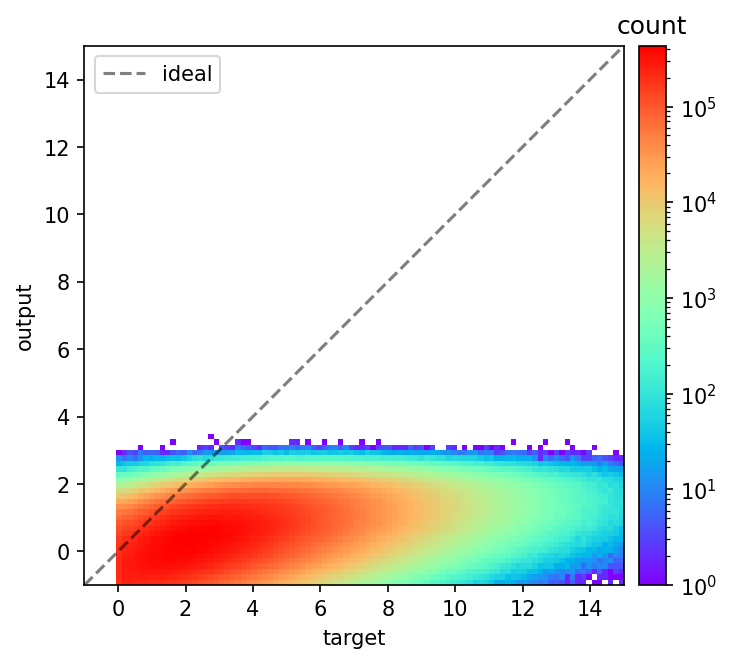

Epoch 6/10
train Loss:9.5934 Timer:356.4048
val Loss:9.3617 Timer:30.5040
Epoch 7/10
train Loss:9.1695 Timer:359.5226
val Loss:8.9129 Timer:29.0160
Epoch 8/10
train Loss:8.7358 Timer:363.5946
val Loss:8.4779 Timer:29.0201
Epoch 9/10
train Loss:8.3217 Timer:353.8993
val Loss:8.0948 Timer:28.7126
Epoch 10/10
train Loss:7.9426 Timer:354.0710
val Loss:7.7427 Timer:50.9648


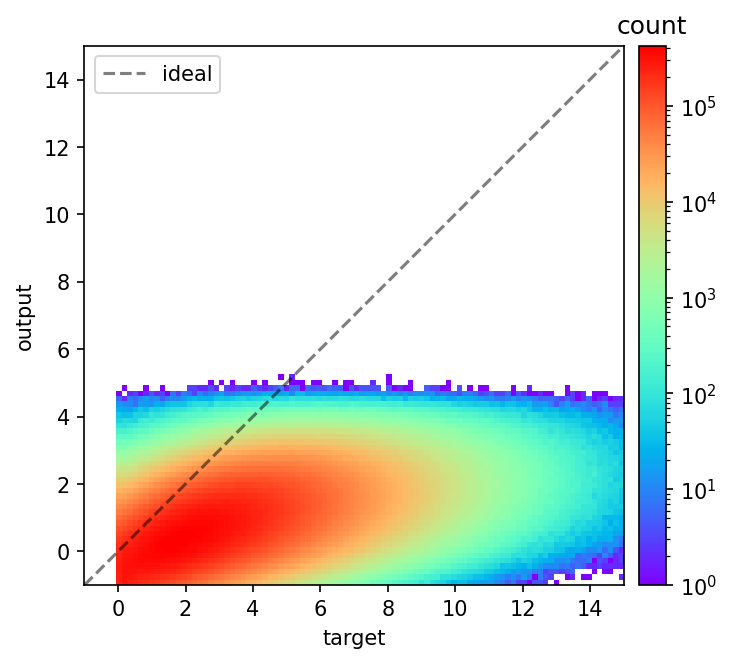

[I 2022-03-21 00:20:07,442] Trial 10 finished with value: 7.742675327911377 and parameters: {'model': 'CTC', 'lr': 1.5903570404154496e-05, 'weight_decay': 1.4272869488630704e-07}. Best is trial 1 with value: 2.775973423614502.


model:CTC, lr:3.342e-04, wd:9.803e-04
Epoch 1/10
val Loss:12.1685 Timer:34.3962
Epoch 2/10
train Loss:8.7114 Timer:361.1056
val Loss:5.8204 Timer:33.1541
Epoch 3/10
train Loss:4.1561 Timer:360.5994
val Loss:3.0606 Timer:32.9441
Epoch 4/10
train Loss:2.8473 Timer:357.3777
val Loss:2.7822 Timer:32.2942
Epoch 5/10
train Loss:2.7836 Timer:364.1427
val Loss:2.7612 Timer:55.7234


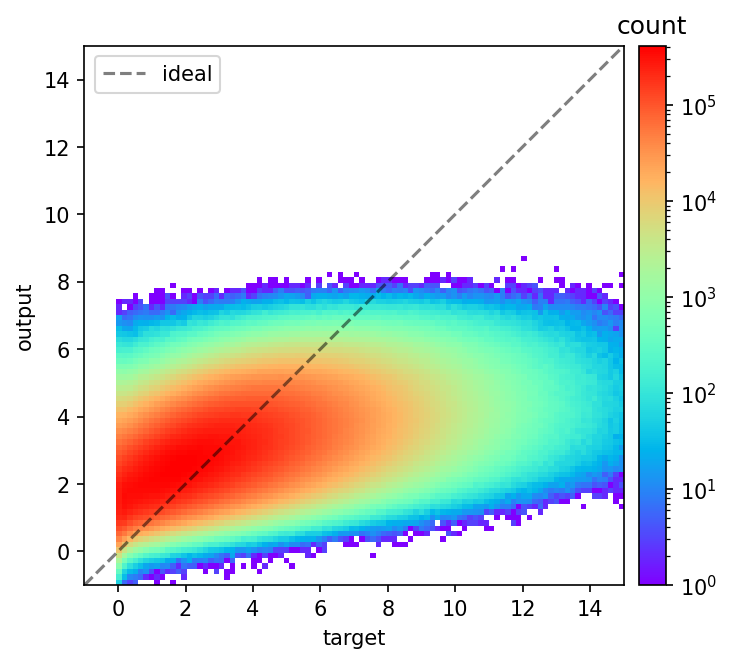

Epoch 6/10
train Loss:2.7718 Timer:359.8508
val Loss:2.7549 Timer:28.8653
Epoch 7/10
train Loss:2.7675 Timer:351.0450
val Loss:2.7498 Timer:27.8069
Epoch 8/10
train Loss:2.7617 Timer:360.1215
val Loss:2.7480 Timer:28.0905
Epoch 9/10
train Loss:2.7587 Timer:359.5474
val Loss:2.7501 Timer:29.7048
Epoch 10/10
train Loss:2.7563 Timer:358.5921
val Loss:2.7485 Timer:52.9156


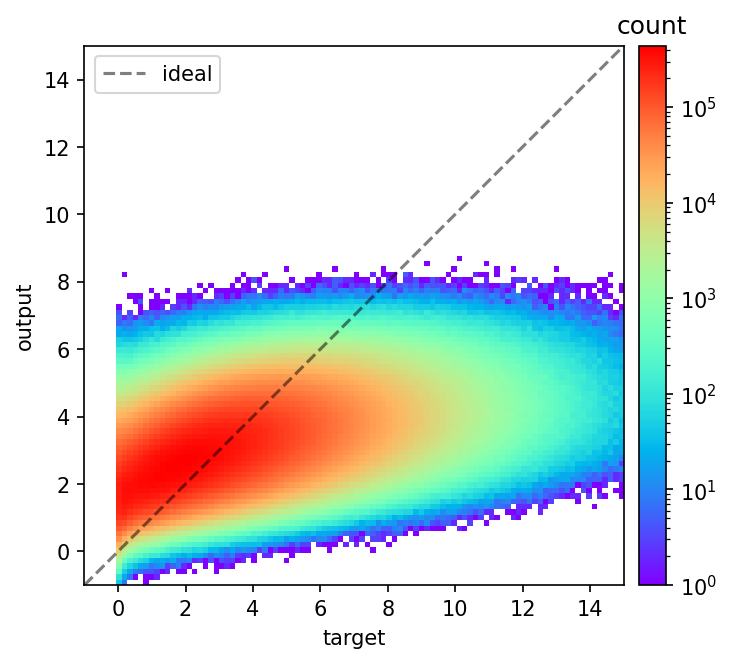

[I 2022-03-21 01:20:22,696] Trial 11 finished with value: 2.748514584528605 and parameters: {'model': 'CTC', 'lr': 0.00033417065534543683, 'weight_decay': 0.0009803458145475341}. Best is trial 11 with value: 2.748514584528605.


model:CTC, lr:5.686e-04, wd:9.783e-04
Epoch 1/10
val Loss:12.1874 Timer:31.3357
Epoch 2/10
train Loss:7.4781 Timer:361.4977
val Loss:3.9771 Timer:32.6866
Epoch 3/10
train Loss:3.0599 Timer:359.7934
val Loss:2.7893 Timer:36.2242
Epoch 4/10
train Loss:2.7876 Timer:357.3565
val Loss:2.7697 Timer:32.1202
Epoch 5/10
train Loss:2.7781 Timer:363.2541
val Loss:2.7650 Timer:59.7170


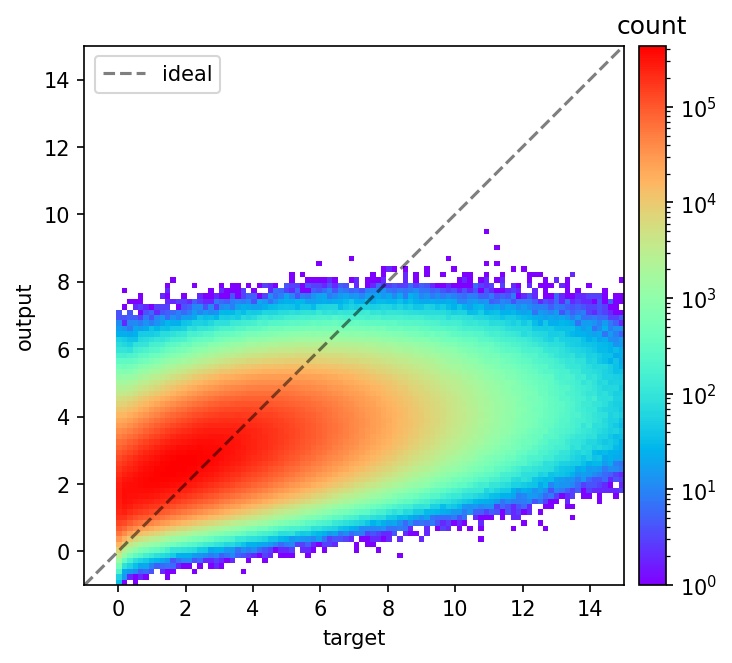

Epoch 6/10
train Loss:2.7706 Timer:356.7224
val Loss:2.7483 Timer:29.1572
Epoch 7/10
train Loss:2.7592 Timer:359.8173
val Loss:2.7408 Timer:28.7795
Epoch 8/10
train Loss:2.7551 Timer:352.5887
val Loss:2.7372 Timer:27.8497
Epoch 9/10
train Loss:2.7531 Timer:349.3828
val Loss:2.7387 Timer:29.3425
Epoch 10/10
train Loss:2.7520 Timer:352.2169
val Loss:2.7399 Timer:50.9354


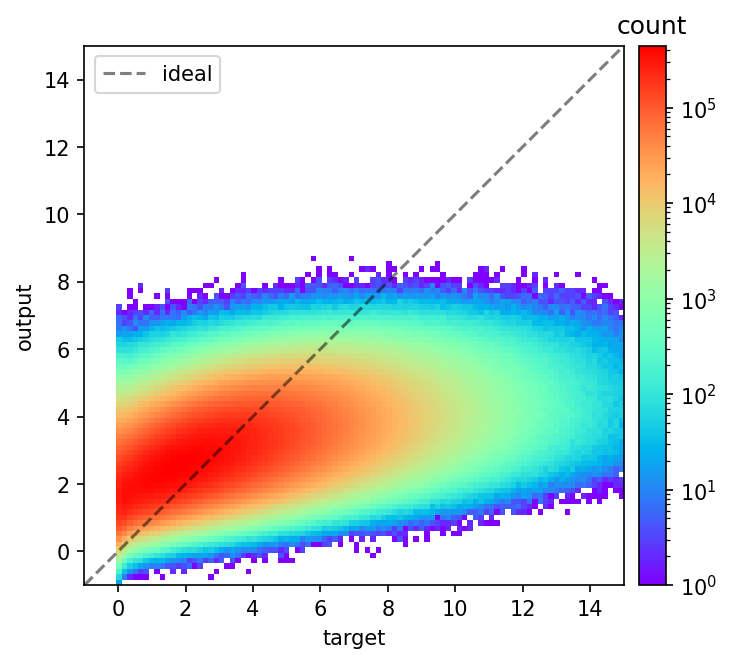

[I 2022-03-21 02:20:21,917] Trial 12 finished with value: 2.7399418819936114 and parameters: {'model': 'CTC', 'lr': 0.0005686346370819349, 'weight_decay': 0.000978307406379977}. Best is trial 12 with value: 2.7399418819936114.


model:CTC, lr:6.766e-03, wd:8.105e-04
Epoch 1/10
val Loss:12.2995 Timer:29.2569
Epoch 2/10
train Loss:3.8727 Timer:355.5006
val Loss:2.9977 Timer:30.1433
Epoch 3/10
train Loss:3.2582 Timer:361.1113
val Loss:3.1591 Timer:28.3905
Epoch 4/10
train Loss:3.1211 Timer:360.9077
val Loss:3.1361 Timer:27.7963
Epoch 5/10
train Loss:3.2230 Timer:358.3705
val Loss:3.2204 Timer:52.6652


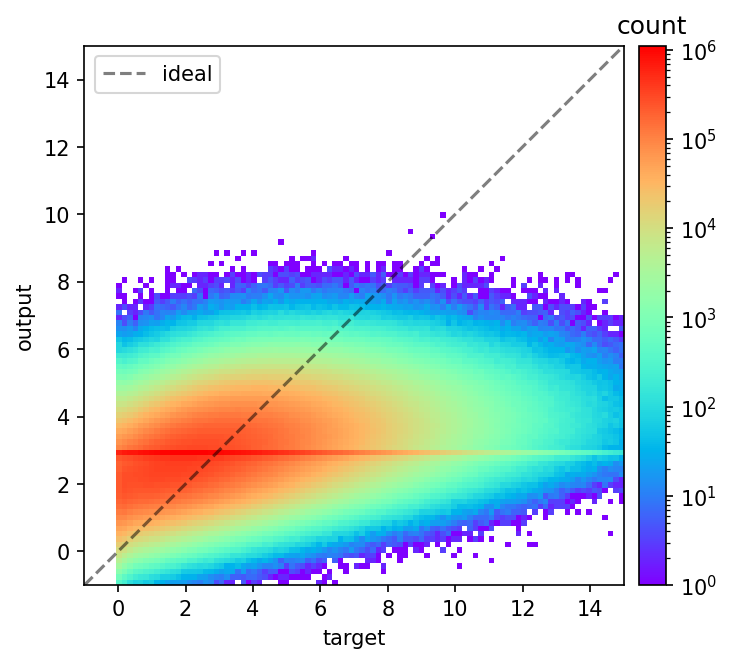

Epoch 6/10
train Loss:3.1898 Timer:359.3544
val Loss:3.1718 Timer:27.7827
Epoch 7/10
train Loss:3.1781 Timer:354.8808
val Loss:3.1712 Timer:27.7084
Epoch 8/10
train Loss:3.1754 Timer:353.6323
val Loss:3.1765 Timer:27.6134
Epoch 9/10
train Loss:3.1743 Timer:359.7134
val Loss:3.1751 Timer:27.3948
Epoch 10/10
train Loss:3.1623 Timer:354.7096
val Loss:3.1505 Timer:50.1193


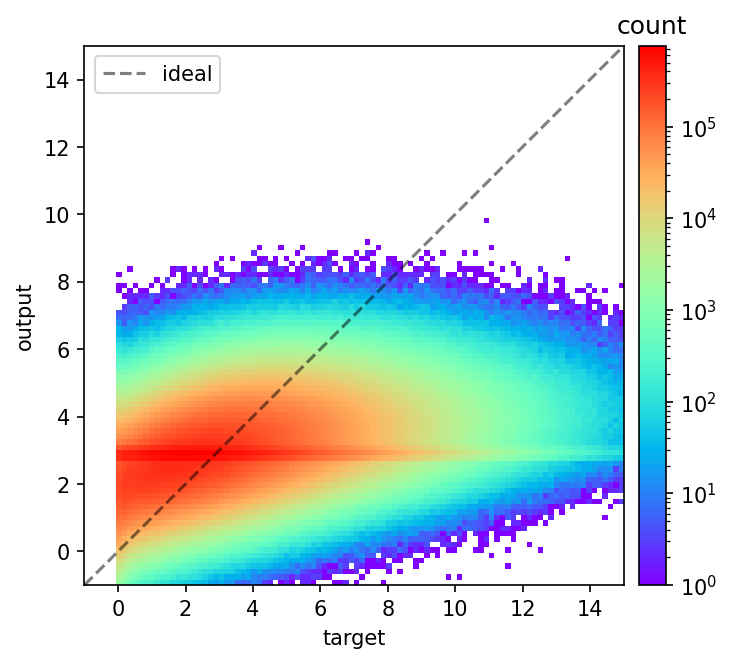

[I 2022-03-21 03:19:55,546] Trial 13 finished with value: 3.1505178783162435 and parameters: {'model': 'CTC', 'lr': 0.006765699835023391, 'weight_decay': 0.0008104919441295539}. Best is trial 12 with value: 2.7399418819936114.


model:CTC, lr:7.298e-04, wd:2.200e-04
Epoch 1/10
val Loss:12.1044 Timer:32.7254
Epoch 2/10
train Loss:6.7926 Timer:361.7513
val Loss:3.2732 Timer:34.3984
Epoch 3/10
train Loss:2.8139 Timer:361.3996
val Loss:2.7094 Timer:33.3898
Epoch 4/10
train Loss:2.7204 Timer:364.7152
val Loss:2.7035 Timer:32.0804
Epoch 5/10
train Loss:2.7160 Timer:356.4961
val Loss:2.7028 Timer:55.7930


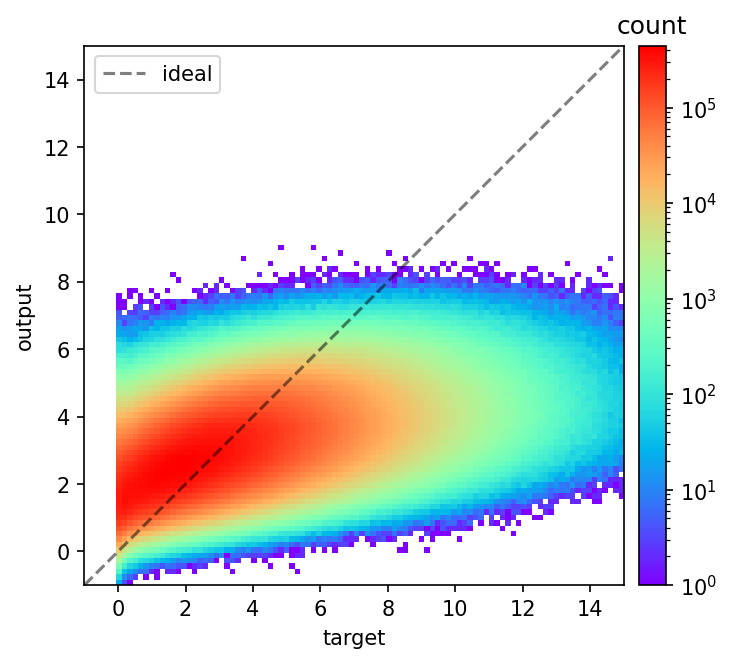

Epoch 6/10
train Loss:2.7115 Timer:364.2576
val Loss:2.6930 Timer:28.1174
Epoch 7/10
train Loss:2.7079 Timer:360.3684
val Loss:2.6894 Timer:27.7572
Epoch 8/10
train Loss:2.7045 Timer:358.9436
val Loss:2.6885 Timer:27.9502
Epoch 9/10
train Loss:2.7010 Timer:358.5485
val Loss:2.6821 Timer:32.3520
Epoch 10/10
train Loss:2.6991 Timer:355.3999
val Loss:2.6819 Timer:48.8315


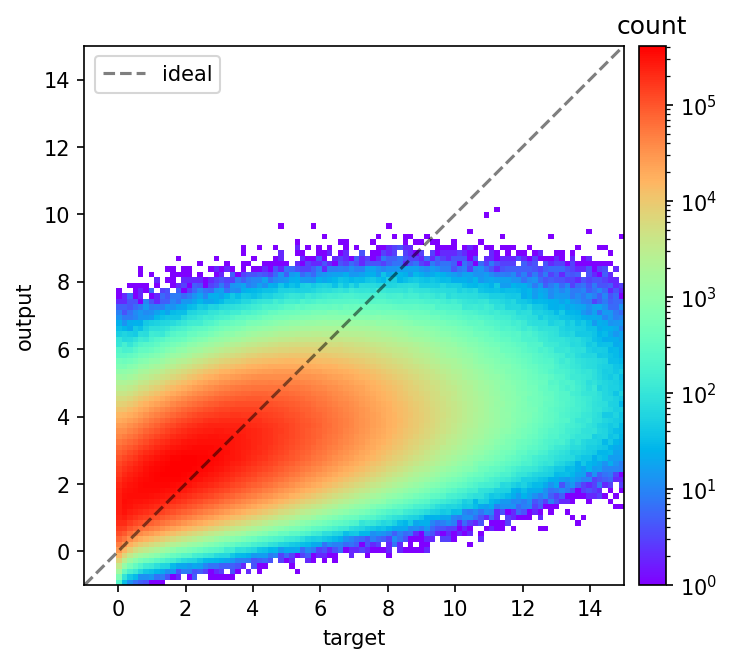

[I 2022-03-21 04:20:18,622] Trial 14 finished with value: 2.6819064628601073 and parameters: {'model': 'CTC', 'lr': 0.0007297754838865531, 'weight_decay': 0.00021995022779130335}. Best is trial 14 with value: 2.6819064628601073.


model:CTC, lr:1.102e-03, wd:1.509e-04
Epoch 1/10
val Loss:12.3678 Timer:32.0068
Epoch 2/10
train Loss:5.8742 Timer:358.2301
val Loss:2.8227 Timer:33.3789
Epoch 3/10
train Loss:2.7504 Timer:364.6513
val Loss:2.7120 Timer:32.9423
Epoch 4/10
train Loss:2.7250 Timer:370.3759
val Loss:2.7022 Timer:33.7861
Epoch 5/10
train Loss:2.7190 Timer:356.4795
val Loss:2.6966 Timer:55.8367


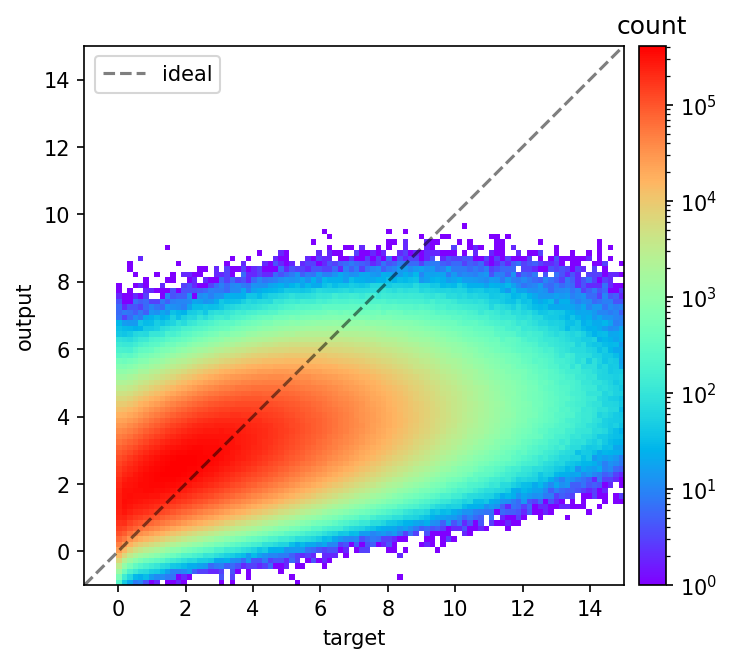

Epoch 6/10
train Loss:2.7161 Timer:354.6476
val Loss:2.7092 Timer:27.7389
Epoch 7/10
train Loss:2.7144 Timer:357.0981
val Loss:2.6954 Timer:28.0844
Epoch 8/10
train Loss:2.7134 Timer:352.5992
val Loss:2.6935 Timer:27.5888
Epoch 9/10
train Loss:2.7127 Timer:355.2892
val Loss:2.6934 Timer:27.6288
Epoch 10/10
train Loss:2.7120 Timer:354.6014
val Loss:2.6935 Timer:49.0944


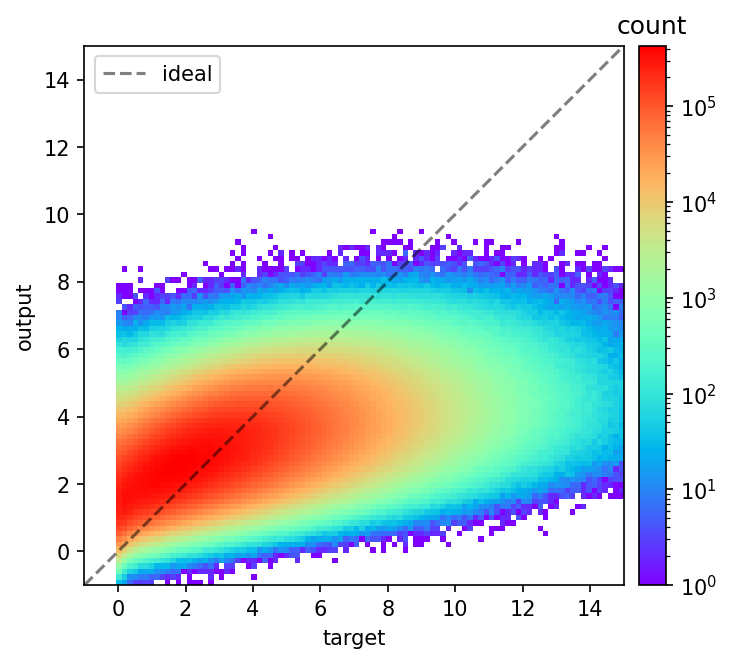

[I 2022-03-21 05:20:17,493] Trial 15 finished with value: 2.6935239681752523 and parameters: {'model': 'CTC', 'lr': 0.0011021010901003528, 'weight_decay': 0.00015086573174385968}. Best is trial 14 with value: 2.6819064628601073.


model:TC, lr:7.541e-03, wd:1.835e-04
Epoch 1/10
val Loss:12.4704 Timer:9.3858
Epoch 2/10
train Loss:4.4414 Timer:86.3362
val Loss:3.7741 Timer:9.3834
Epoch 3/10
train Loss:3.7777 Timer:90.9464
val Loss:3.7773 Timer:9.5345
Epoch 4/10
train Loss:3.7799 Timer:88.7785
val Loss:3.7776 Timer:9.8621
Epoch 5/10
train Loss:3.7799 Timer:90.8842
val Loss:3.7773 Timer:32.8097


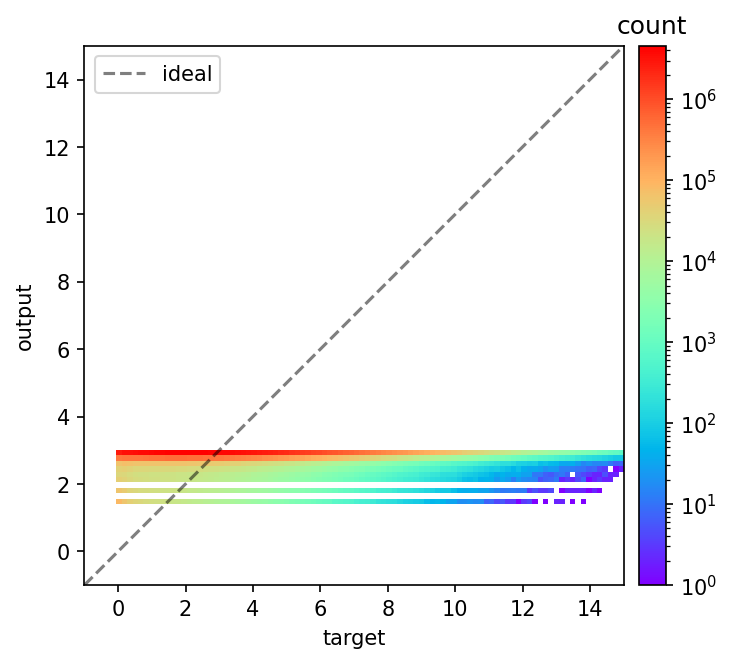

Epoch 6/10
train Loss:3.7798 Timer:83.8449
val Loss:3.7776 Timer:5.9719
Epoch 7/10
train Loss:3.7799 Timer:84.0046
val Loss:3.7773 Timer:6.7725
Epoch 8/10
train Loss:3.7799 Timer:82.2759
val Loss:3.7773 Timer:5.9764
Epoch 9/10
train Loss:3.7799 Timer:84.4321
val Loss:3.7773 Timer:6.0733
Epoch 10/10
train Loss:3.7799 Timer:81.6609
val Loss:3.7774 Timer:26.9193


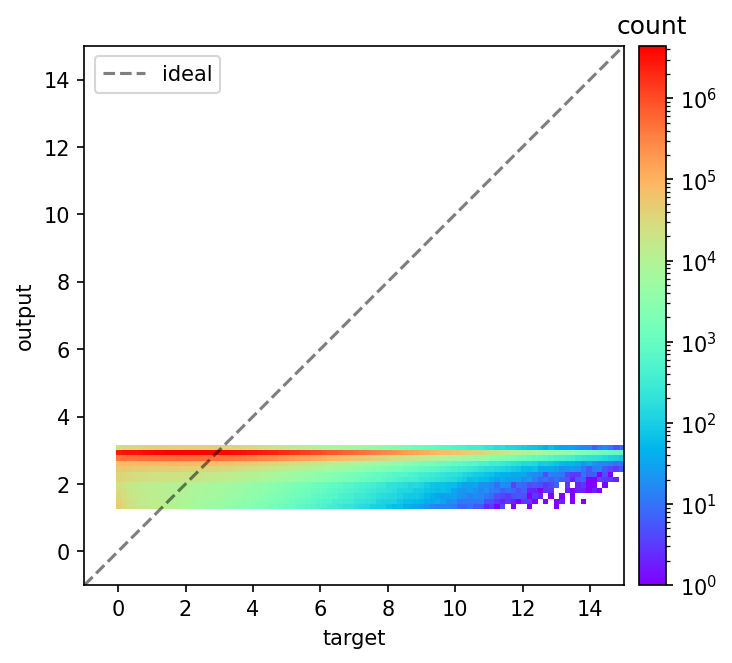

[I 2022-03-21 05:35:35,485] Trial 16 finished with value: 3.7773624166107176 and parameters: {'model': 'TC', 'lr': 0.007540589513918228, 'weight_decay': 0.00018354708768795441}. Best is trial 14 with value: 2.6819064628601073.


model:CTC, lr:2.051e-03, wd:1.195e-04
Epoch 1/10
val Loss:12.5629 Timer:31.8622
Epoch 2/10
train Loss:4.7514 Timer:352.8155
val Loss:2.7679 Timer:33.3393
Epoch 3/10
train Loss:2.7724 Timer:356.1675
val Loss:2.7560 Timer:31.6401
Epoch 4/10
train Loss:2.7636 Timer:357.6995
val Loss:2.7503 Timer:31.5858
Epoch 5/10
train Loss:2.7594 Timer:354.7307
val Loss:2.7461 Timer:54.7746


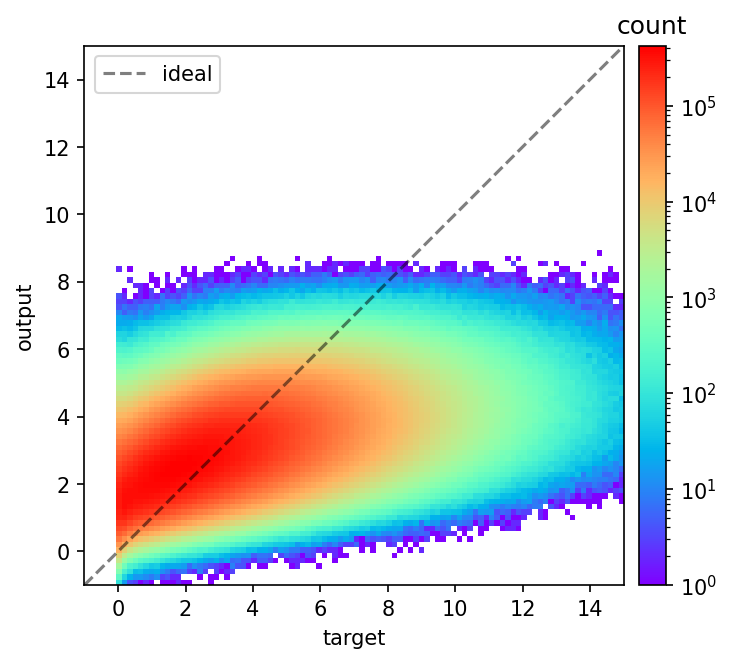

Epoch 6/10
train Loss:2.7566 Timer:361.1193
val Loss:2.7421 Timer:28.7441
Epoch 7/10
train Loss:2.7545 Timer:356.4490
val Loss:2.7533 Timer:32.8985
Epoch 8/10
train Loss:2.7520 Timer:358.1364
val Loss:2.7467 Timer:28.3152
Epoch 9/10
train Loss:2.7406 Timer:346.7120
val Loss:2.7265 Timer:28.5815
Epoch 10/10
train Loss:2.7324 Timer:359.0167
val Loss:2.7137 Timer:50.2529


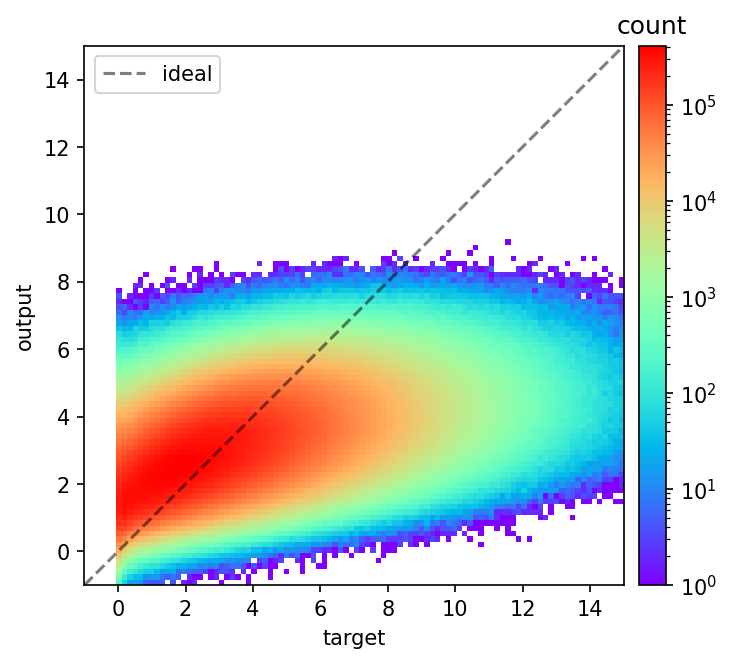

[I 2022-03-21 06:35:17,280] Trial 17 finished with value: 2.7137353618367515 and parameters: {'model': 'CTC', 'lr': 0.002051212618540313, 'weight_decay': 0.00011946639233848205}. Best is trial 14 with value: 2.6819064628601073.


model:CTC, lr:1.098e-03, wd:2.815e-04
Epoch 1/10
val Loss:12.3504 Timer:28.0894
Epoch 2/10
train Loss:5.8715 Timer:362.1259
val Loss:2.8373 Timer:29.1372
Epoch 3/10
train Loss:2.7771 Timer:360.5293
val Loss:2.7535 Timer:27.8316
Epoch 4/10
train Loss:2.7608 Timer:353.0679
val Loss:2.7438 Timer:28.9637
Epoch 5/10
train Loss:2.7324 Timer:358.1376
val Loss:2.7092 Timer:52.2840


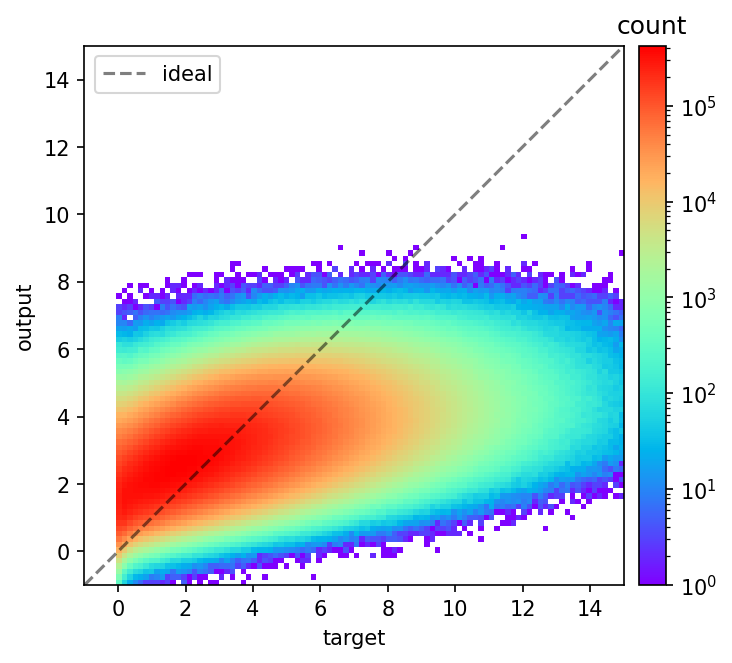

Epoch 6/10
train Loss:2.7243 Timer:367.9019
val Loss:2.7049 Timer:27.7893
Epoch 7/10
train Loss:2.7216 Timer:348.6304
val Loss:2.7048 Timer:28.5338
Epoch 8/10
train Loss:2.7196 Timer:350.1995
val Loss:2.7026 Timer:27.3604
Epoch 9/10
train Loss:2.7187 Timer:348.4892
val Loss:2.7153 Timer:31.2236
Epoch 10/10
train Loss:2.7184 Timer:354.8250
val Loss:2.7037 Timer:51.2232


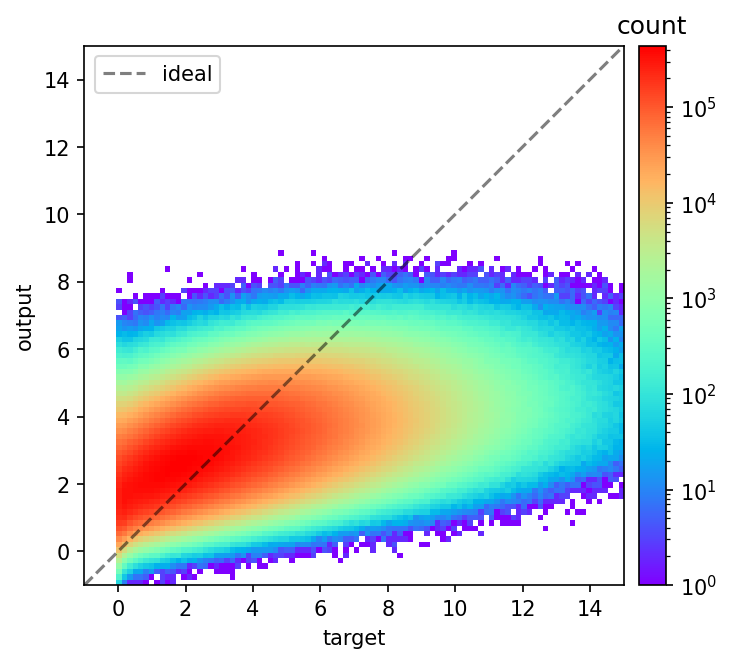

[I 2022-03-21 07:34:40,855] Trial 18 finished with value: 2.703664390106201 and parameters: {'model': 'CTC', 'lr': 0.0010976858225287126, 'weight_decay': 0.00028149654215156854}. Best is trial 14 with value: 2.6819064628601073.


model:CTC, lr:3.624e-03, wd:2.685e-05
Epoch 1/10
val Loss:12.5970 Timer:32.0468
Epoch 2/10
train Loss:4.0567 Timer:369.7662
val Loss:2.7400 Timer:33.8236
Epoch 3/10
train Loss:3.3370 Timer:359.2289
val Loss:3.7769 Timer:32.2407
Epoch 4/10
train Loss:3.6054 Timer:361.8164
val Loss:3.4244 Timer:33.6313
Epoch 5/10
train Loss:3.3815 Timer:360.3331
val Loss:3.3530 Timer:56.2050


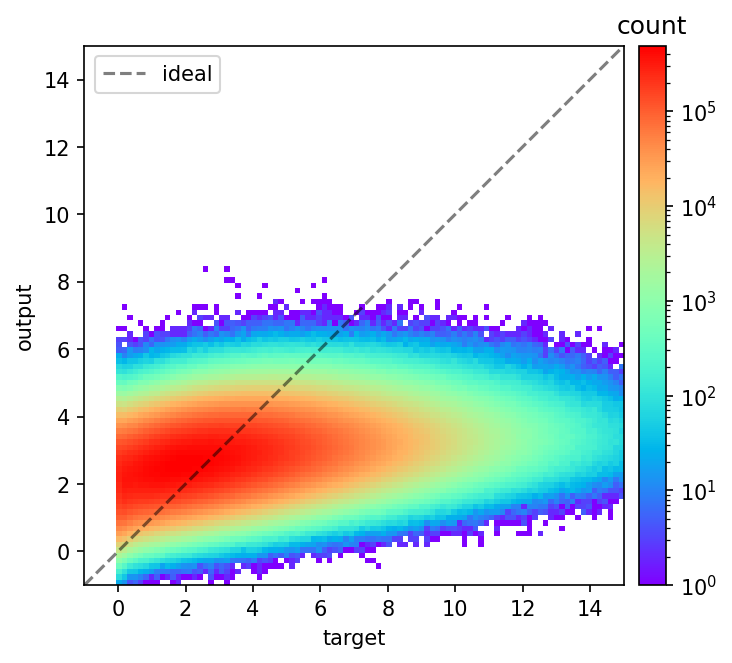

Epoch 6/10


In [ ]:
trial = 50
study = optuna.create_study()
study.optimize(objective, n_trials=trial)

print(study.best_params)
print(study.best_value)